# Dataset Simulation (Sanjida)

In [ ]:
RUN_LLM = False                # True to load Mistral / generate seeds. Set False after seeds are produced.
RUN_LLM_STRUCT = False        # If True, attempt to use LLM to produce structured sample rows
HF_TOKEN = "YOUR_TOKEN"     # Replace with your HF token if RUN_LLM True

N_FINAL = 1000                # final dataset size
SEED_STRUCT_N = 200           # structured sample rows for CTGAN training
URGENT_PROB = 0.35            # probability a ticket is urgent in generated samples
RNG_SEED = 42                 # reproducibility
OUT_CSV = "synthetic_support_tickets.csv"

In [ ]:
!pip install sdv transformers accelerate bitsandbytes huggingface_hub --quiet

In [ ]:
import random, re, math
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# SDV / CTGAN imports
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

# RNG
rng = np.random.default_rng(RNG_SEED)

# LLM setup (guarded)
tokenizer = None
model = None
device = "cpu"

if RUN_LLM:
    import os
    import torch
    from huggingface_hub import login
    from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, logging as hf_logging

    # login (programmatic)
    os.environ["HUGGINGFACE_TOKEN"] = HF_TOKEN
    try:
        login(token=HF_TOKEN)
    except Exception:
        pass

    # Silence transformer info logs (prevents repeated pad messages)
    hf_logging.set_verbosity_error()

    model_name = "mistralai/Mistral-7B-Instruct-v0.1"
    bnb = BitsAndBytesConfig(load_in_4bit=True)

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False, token=os.environ.get("HUGGINGFACE_TOKEN"))
    # Ensure pad_token exists
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb,
        device_map="auto",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    )
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

# Safe generate that returns only the generated text (no prompt)
def generate_reply_only(prompt, max_new_tokens=100, retries=2):
    """Generate and return only the model-generated text (without the prompt)."""
    assert RUN_LLM and model is not None and tokenizer is not None, "LLM not enabled"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
    input_ids = inputs["input_ids"]
    input_len = input_ids.shape[1]

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=0.8,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        top_p=0.95
    )
    gen_ids = outputs[0, input_len:]
    text = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()

    tries = 0
    while (not text or text.strip() == "") and tries < retries:
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.9,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            top_p=0.95
        )
        gen_ids = outputs[0, input_len:]
        text = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()
        tries += 1

    # Collapse whitespace/newlines into single line and return
    text = " ".join(text.split())
    return text

In [ ]:
# Helper lists
first_names = ["Aisha","Adam","Nur","Sanjida","Hannah","Ibrahim","Amina","Daniel","Siti","Ravi","Wei","Sara","Amir","Lina"]
product_categories = ["Electronics","Clothing","Home","Beauty","Groceries"]
issue_types = ["Payment","Delivery","Product","Refund","Other"]

def make_structured_row(i, urgent_prob=URGENT_PROB):
    urgent = int(rng.random() < urgent_prob)
    ticket_dt = (datetime.now() - timedelta(days=int(rng.integers(0, 90)),
                                           seconds=int(rng.integers(0, 86400))))
    ticket_dt_str = ticket_dt.strftime("%Y-%m-%d %H:%M:%S")  # no microseconds
    return {
        "ticket_id": f"T{i:05d}",
        "customer_id": f"C{rng.integers(1000, 9999)}",
        "ticket_date": ticket_dt_str,
        "account_age_days": int(rng.integers(30, 2000)),
        "num_prev_tickets": int(rng.poisson(2) if urgent else int(rng.poisson(1))),
        "avg_response_time_prev": round(float(rng.uniform(2, 48)), 2),
        "product_category": random.choice(product_categories),
        "issue_type": random.choice(issue_types),
        "priority": "High" if urgent else random.choice(["Low", "Medium"]),
        "urgent_flag": int(urgent)
    }

# Build sample
structured_sample = []
if RUN_LLM_STRUCT and RUN_LLM:
    pass

for i in range(SEED_STRUCT_N):
    structured_sample.append(make_structured_row(i))

df_seed_struct = pd.DataFrame(structured_sample)
print("Structured seed shape:", df_seed_struct.shape)
df_seed_struct.head()

In [ ]:
# Use only structured columns for CTGAN
ctgan_columns = ["customer_id","ticket_date","account_age_days",
                 "num_prev_tickets","avg_response_time_prev",
                 "product_category","issue_type","priority","urgent_flag"]

df_ctgan_train = df_seed_struct[ctgan_columns].copy()

# For CTGAN, ticket_date should be convertible to a numeric or categorical representation.
# Option: convert ticket_date to "days_ago" integer for CTGAN, then convert back later.
def date_to_days_ago(dt_str):
    dt = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S")
    return (datetime.now() - dt).days

df_ctgan_train["days_ago"] = df_ctgan_train["ticket_date"].apply(date_to_days_ago)
df_ctgan_train = df_ctgan_train.drop(columns=["ticket_date"])

# Ensure correct dtypes
df_ctgan_train["account_age_days"] = df_ctgan_train["account_age_days"].astype(int)
df_ctgan_train["num_prev_tickets"] = df_ctgan_train["num_prev_tickets"].astype(int)
df_ctgan_train["avg_response_time_prev"] = df_ctgan_train["avg_response_time_prev"].astype(float)
df_ctgan_train["urgent_flag"] = df_ctgan_train["urgent_flag"].astype(int)

# Build metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_ctgan_train)

# Train CTGAN
ctgan = CTGANSynthesizer(metadata)
ctgan.fit(df_ctgan_train)

to_generate = N_FINAL - len(df_ctgan_train)
print(f"Generating {to_generate} synthetic structured rows with CTGAN...")
synthetic_struct = ctgan.sample(to_generate)

# Combine seed + synthetic
df_struct_all = pd.concat([df_ctgan_train, synthetic_struct], ignore_index=True)
# Reconstruct ticket_date from days_ago (randomize time-of-day)
def days_ago_to_date(days):
    # randomize time-of-day
    secs = int(rng.integers(0, 86400))
    dt = datetime.now() - timedelta(days=int(days), seconds=secs)
    return dt.strftime("%Y-%m-%d %H:%M:%S")

df_struct_all["ticket_date"] = df_struct_all["days_ago"].apply(days_ago_to_date)
df_struct_all = df_struct_all.drop(columns=["days_ago"])  # done

# Reorder and ensure columns
df_struct_all = df_struct_all[["customer_id","ticket_date","account_age_days",
                               "num_prev_tickets","avg_response_time_prev",
                               "product_category","issue_type","priority","urgent_flag"]]

# Assign ticket_id sequentially T00000..T00999 and keep consistent
df_struct_all.insert(0, "ticket_id", [f"T{i:05d}" for i in range(len(df_struct_all))])

print("Combined structured dataset shape:", df_struct_all.shape)
df_struct_all.head()

In [ ]:
rows = []
first_names = ["Aisha","Adam","Nur","Sanjida","Hannah","Ibrahim","Amina","Daniel","Siti","Ravi","Wei","Sara","Amir","Lina"]

PROMPT_TEMPLATE = """You are a customer writing a support ticket for an e-commerce platform.
Tone: {tone}
Context: {issue_type} issue for a {product_category} item.
Write a 1–2 sentence realistic ticket (avoid placeholders like [Your Name] or [Order number])."""

for idx, r in df_struct_all.reset_index(drop=True).iterrows():
    urgent = int(r["urgent_flag"])
    tone = "urgent and frustrated" if urgent == 1 else "calm and non-urgent"
    prompt = PROMPT_TEMPLATE.format(tone=tone, issue_type=r["issue_type"], product_category=r["product_category"])

    # Generate ticket_text per row (unique)
    ticket_text = generate_reply_only(prompt, max_new_tokens=100)

    # Replace any leftover placeholders
    name = random.choice(first_names)
    order_no = f"ORD{rng.integers(100000,999999)}"
    ticket_text = re.sub(r"\[Your Name\]|\{Your Name\}", name, ticket_text)
    ticket_text = re.sub(r"\[Order number\]|\{Order number\}|\[order number\]", order_no, ticket_text)
    ticket_text = " ".join(ticket_text.split())

    row = {
        "ticket_id": r["ticket_id"],
        "customer_id": r["customer_id"],
        "ticket_date": r["ticket_date"],
        "account_age_days": int(r["account_age_days"]),
        "num_prev_tickets": int(r["num_prev_tickets"]),
        "avg_response_time_prev": float(r["avg_response_time_prev"]),
        "product_category": r["product_category"],
        "issue_type": r["issue_type"],
        "priority": r["priority"],
        "ticket_text": ticket_text,
        "urgent_flag": urgent
    }
    rows.append(row)

df_final = pd.DataFrame(rows)
df_final.to_csv("synthetic_support_tickets_unique.csv", index=False)
print("Saved 1000 fully unique tickets in synthetic_support_tickets_unique.csv")

In [ ]:
df_final.head()

# Load Synthetic Dataset

In [281]:
from google.colab import files

uploaded = files.upload()

Saving synthetic_support_tickets_unique.csv to synthetic_support_tickets_unique (3).csv


In [282]:
import pandas as pd

# Load the CSV
df = pd.read_csv('synthetic_support_tickets_unique.csv')

# Preview the data
df.head()

,ticket_id,customer_id,ticket_date,account_age_days,num_prev_tickets,avg_response_time_prev,product_category,issue_type,priority,ticket_text,urgent_flag
0,T00000,C4896,2025-11-06 02:10:45,1721,1,46.88,Beauty,Delivery,Medium,Subject: Beauty item delivery issue Dear Suppo...,0
1,T00001,C5618,2025-10-30 19:14:40,282,1,44.63,Electronics,Refund,Low,I purchased an Electronics item on your websit...,0
2,T00002,C5908,2025-11-27 21:36:16,903,0,27.51,Electronics,Other,Medium,"""I recently purchased an Electronics item from...",0
3,T00003,C3490,2025-10-18 08:31:02,1274,5,23.47,Clothing,Delivery,High,Subject: Urgent Delivery Issue for Clothing It...,1
4,T00004,C7689,2025-11-15 15:26:34,1375,3,23.60,Clothing,Other,High,Subject: Urgent: Problem with Clothing item - ...,1


# Simple EDA (Sanjida)

In [283]:
# Basic structure
print("Dataset size:", df.shape)

print("\nDataset info:")
df.info()

# Missing values
print("\nMissing values:\n",df.isnull().sum())

Dataset size: (1000, 11)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ticket_id               1000 non-null   object 
 1   customer_id             1000 non-null   object 
 2   ticket_date             1000 non-null   object 
 3   account_age_days        1000 non-null   int64  
 4   num_prev_tickets        1000 non-null   int64  
 5   avg_response_time_prev  1000 non-null   float64
 6   product_category        1000 non-null   object 
 7   issue_type              1000 non-null   object 
 8   priority                1000 non-null   object 
 9   ticket_text             1000 non-null   object 
 10  urgent_flag             1000 non-null   int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 86.1+ KB

Missing values:
 ticket_id                 0
customer_id               0
ticket_date               0


In [284]:
# Target variable distribution
df['urgent_flag'].value_counts()

,count
urgent_flag,
0,519
1,481


The target variable urgent_flag is well balanced, with 51.9% non-urgent and 48.1% urgent cases, indicating no class imbalance issue.

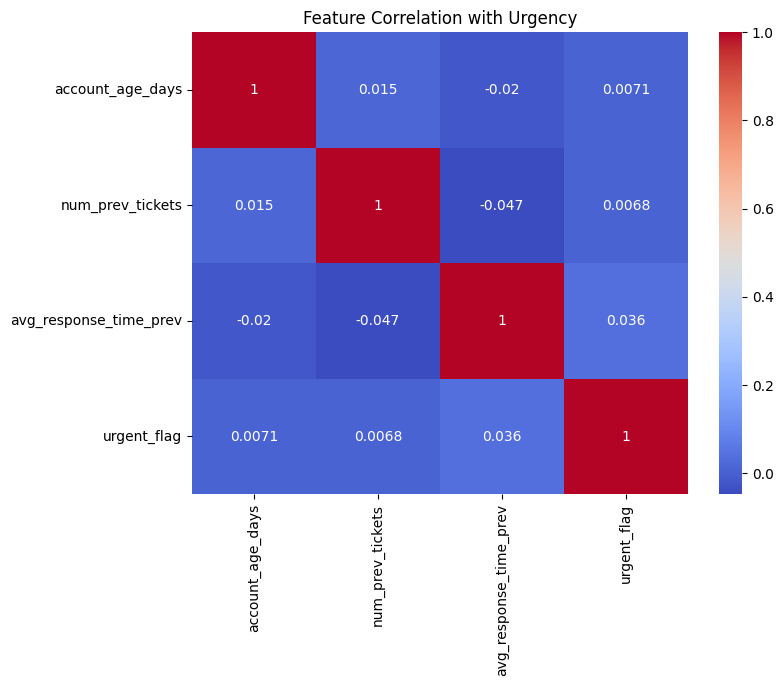

In [285]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns only
numeric_cols = ["account_age_days", "num_prev_tickets", "avg_response_time_prev"]

plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols + ["urgent_flag"]].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation with Urgency")
plt.show()

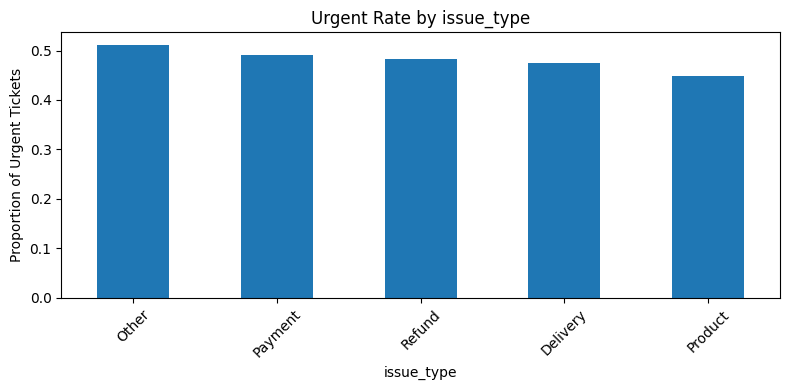

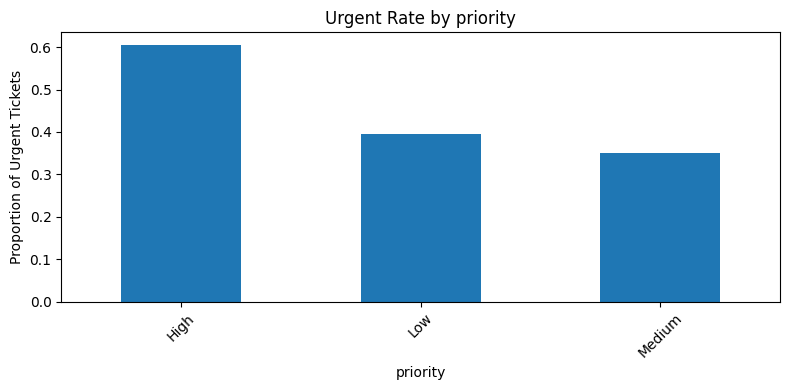

In [286]:
# Urgent_flag rate by issue_type and priority
categorical_cols = ["issue_type", "priority"]

for col in categorical_cols:
    temp = df.groupby(col)["urgent_flag"].mean().sort_values(ascending=False)

    plt.figure(figsize=(8,4))
    temp.plot(kind="bar")
    plt.ylabel("Proportion of Urgent Tickets")
    plt.title(f"Urgent Rate by {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

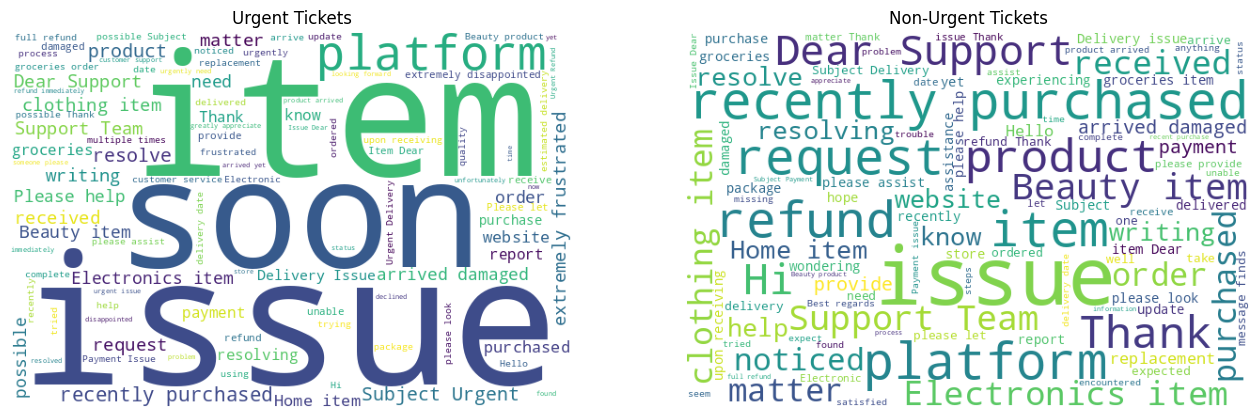

In [287]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Split text by urgency
urgent_text = " ".join(df[df["urgent_flag"]==1]["ticket_text"].dropna())
nonurgent_text = " ".join(df[df["urgent_flag"]==0]["ticket_text"].dropna())

# Generate word clouds
wc_urgent = WordCloud(width=600, height=400, max_words=100, background_color="white").generate(urgent_text)
wc_nonurgent = WordCloud(width=600, height=400, max_words=100, background_color="white").generate(nonurgent_text)

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.imshow(wc_urgent)
plt.axis("off")
plt.title("Urgent Tickets")

plt.subplot(1,2,2)
plt.imshow(wc_nonurgent)
plt.axis("off")
plt.title("Non-Urgent Tickets")

plt.show()

The urgent_flag primarily depends on linguistic patterns in the ticket_text column that reflect urgency, as well as on the priority column.

# Feature Engineering 1 (Syarifah)

In [288]:
# imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report
)

# Sentiment analysis
from textblob import TextBlob

In [289]:
# FE Task 1 — Sentiment Score

def compute_sentiment(text):
    """
    Compute sentiment polarity score using TextBlob.
    Returns value in range [-1, 1].
    """
    if pd.isna(text) or text.strip() == "":
        return 0.0
    return TextBlob(text).sentiment.polarity

df["sentiment_score"] = df["ticket_text"].apply(compute_sentiment)

df["sentiment_score"].describe()

,sentiment_score
count,1000.000000
mean,-0.071125
std,0.183227
min,-0.750000
25%,-0.181027
50%,-0.072222
75%,0.000000
max,0.775000


In [290]:
# FE Task 1 — Urgent Keyword Flag

urgent_keywords = [
    "urgent", "asap", "immediately", "critical",
    "important", "failure", "system down",
    "error", "cannot access", "crash", "down"
]

def urgent_flag(text):
    """
    Detect presence of urgency-related keywords.
    Returns 1 if urgent keyword found, else 0.
    """
    if pd.isna(text):
        return 0
    text = text.lower()
    return int(any(keyword in text for keyword in urgent_keywords))

df["urgent_keywords_flag"] = df["ticket_text"].apply(urgent_flag)


df["urgent_keywords_flag"].value_counts()

,count
urgent_keywords_flag,
0,656
1,344


# Feature Engineering 2 (Bushra)

In [293]:
# Account Age Bucket

def bucket_account_age(days):
    if days < 90:
        return "New"
    elif days <= 365:
        return "Medium"
    else:
        return "Long"

df["account_age_category"] = df["account_age_days"].apply(bucket_account_age)

In [294]:
# Customer Activity Risk
def activity_risk(row):
    tickets = row["num_prev_tickets"]
    response = row["avg_response_time_prev"]

    if tickets >= 4 or response >= 36:
        return "High"
    elif tickets >= 2 or response >= 24:
        return "Medium"
    else:
        return "Low"

df["activity_level"] = df.apply(activity_risk, axis=1)

# Feature Encoding and Selection

In [295]:
df.head()

,ticket_id,customer_id,ticket_date,account_age_days,num_prev_tickets,avg_response_time_prev,product_category,issue_type,priority,ticket_text,urgent_flag,sentiment_score,urgent_keywords_flag,account_age_category,activity_level
0,T00000,C4896,2025-11-06 02:10:45,1721,1,46.88,Beauty,Delivery,Medium,Subject: Beauty item delivery issue Dear Suppo...,0,0.111111,0,Long,High
1,T00001,C5618,2025-10-30 19:14:40,282,1,44.63,Electronics,Refund,Low,I purchased an Electronics item on your websit...,0,-0.070000,0,Medium,High
2,T00002,C5908,2025-11-27 21:36:16,903,0,27.51,Electronics,Other,Medium,"""I recently purchased an Electronics item from...",0,-0.033333,1,Long,Medium
3,T00003,C3490,2025-10-18 08:31:02,1274,5,23.47,Clothing,Delivery,High,Subject: Urgent Delivery Issue for Clothing It...,1,0.058333,1,Long,High
4,T00004,C7689,2025-11-15 15:26:34,1375,3,23.60,Clothing,Other,High,Subject: Urgent: Problem with Clothing item - ...,1,-0.051042,1,Long,Medium


In [296]:
# Target variable
y = df["urgent_flag"]

# Encode categorical features from feature engineering
age_map = {"New": 0, "Medium": 1, "Long": 2}
df["account_age_cat_enc"] = df["account_age_category"].map(age_map)

activity_map = {"Low": 0, "Medium": 1, "High": 2}
df["activity_level_enc"] = df["activity_level"].map(activity_map)

# Encode priority if you want to include it
priority_map = {"Low": 0, "Medium": 1, "High": 2}
df["priority_enc"] = df["priority"].map(priority_map)

# Select features for modeling
feature_cols = [
    "sentiment_score",        # numeric
    "urgent_keywords_flag",   # binary
    "account_age_cat_enc",    # encoded categorical
    "activity_level_enc",     # encoded categorical
    "priority_enc"            # encoded priority
]

X = df[feature_cols]

# Check shapes
print(X.head())
print(y.value_counts())

   sentiment_score  urgent_keywords_flag  account_age_cat_enc  \
0         0.111111                     0                    2   
1        -0.070000                     0                    1   
2        -0.033333                     1                    2   
3         0.058333                     1                    2   
4        -0.051042                     1                    2   

   activity_level_enc  priority_enc  
0                   2             1  
1                   2             0  
2                   1             1  
3                   2             2  
4                   1             2  
urgent_flag
0    519
1    481
Name: count, dtype: int64


# Decision Tree (Sanjida)

In [297]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import pandas as pd

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Decision Tree classifier
dt_model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,          # lets the tree expand fully
    class_weight="balanced", # handles class imbalance
    random_state=42
)

In [298]:
# Fit model
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)
y_proba = dt_model.predict_proba(X_test)[:, 1]

In [299]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

dt_metrics = {
    "Model": "Decision Tree",
    "Accuracy": accuracy,
    "F1 Score": f1,
    "ROC-AUC": roc_auc
}

print("Decision Tree Metrics:", dt_metrics)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Decision Tree Metrics: {'Model': 'Decision Tree', 'Accuracy': 0.78, 'F1 Score': 0.78, 'ROC-AUC': np.float64(0.7955228365384615)}

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78       104
           1       0.75      0.81      0.78        96

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200



In [300]:
# Feature Importances
importances = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": dt_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nDecision Tree Feature Importances:\n", importances)


Decision Tree Feature Importances:
                 Feature  Importance
1  urgent_keywords_flag    0.437297
0       sentiment_score    0.392787
3    activity_level_enc    0.073553
4          priority_enc    0.053869
2   account_age_cat_enc    0.042495


**Decision Tree Results**

The Decision Tree model achieved an accuracy of 78%, an F1 score of 0.78, and a ROC-AUC of 0.80, showing balanced performance across both urgent and non-urgent tickets. Precision and recall are fairly even between classes, indicating the model is able to correctly identify urgent tickets while maintaining a low false positive rate.

Overall, the Decision Tree provides solid predictive power using the engineered features.

# Logistic Regression (Syarifah)

In [301]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [302]:
# Fit Logistic Regression
log_reg = LogisticRegression(
    max_iter=1000,
    random_state=42
)

log_reg.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [303]:
# Predictions
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]


In [304]:
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

lr_metrics = {
    "Model": "Logistic Regression",
    "Accuracy": accuracy,
    "F1 Score": f1,
    "ROC-AUC": roc_auc
}

lr_metrics

{'Model': 'Logistic Regression',
 'Accuracy': 0.825,
 'F1 Score': 0.8044692737430168,
 'ROC-AUC': np.float64(0.8793569711538461)}

In [305]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       104
           1       0.87      0.75      0.80        96

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200



In [306]:
# Feature Importances
importances = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": log_reg.coef_[0]
}).sort_values(by="Importance", ascending=False)

print("\nLogistic Regression Feature Importances:\n", importances)


Logistic Regression Feature Importances:
                 Feature  Importance
1  urgent_keywords_flag    1.726576
4          priority_enc    0.485621
3    activity_level_enc    0.111664
2   account_age_cat_enc   -0.070360
0       sentiment_score   -0.812676


### Logistic Regression Results

The Logistic Regression model achieved strong performance, with an accuracy of 82.5% and a ROC-AUC score of 0.88. This indicates that sentiment polarity,urgent keyword features, and customer/account activity features capture provides substantial predictive power for identifying urgent support tickets. These results demonstrate that even a relatively simple model like logistic regression can capture meaningful patterns from the engineered features.

# Random Forest (Bushra)

In [307]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [308]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [309]:
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

rf_metrics = {
    "Model": "Random Forest",
    "Accuracy": accuracy,
    "F1 Score": f1,
    "ROC-AUC": roc_auc
}

print(rf_metrics)
print(classification_report(y_test, y_pred))

{'Model': 'Random Forest', 'Accuracy': 0.8, 'F1 Score': 0.7916666666666666, 'ROC-AUC': np.float64(0.8742988782051282)}
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       104
           1       0.79      0.79      0.79        96

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200



In [310]:
importances = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nRandom Forest Feature Importances:\n", importances)



Random Forest Feature Importances:
                 Feature  Importance
0       sentiment_score    0.493345
1  urgent_keywords_flag    0.376745
4          priority_enc    0.064387
3    activity_level_enc    0.036343
2   account_age_cat_enc    0.029180


# XGBoost (Adhia)

In [311]:
X_xgb = X.copy()
y_xgb = y.copy()

In [312]:
from sklearn.model_selection import train_test_split

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb,
    y_xgb,
    test_size=0.2,
    random_state=42,
    stratify=y_xgb
)

In [313]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [314]:
xgb_model.fit(X_train_xgb, y_train_xgb)

y_pred_xgb = xgb_model.predict(X_test_xgb)
y_prob_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

In [315]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

accuracy_score(y_test_xgb, y_pred_xgb)
f1 = f1_score(y_test_xgb, y_pred_xgb)
roc_auc = roc_auc_score(y_test_xgb, y_prob_xgb)

xgb_metrics = {
    "Model": "XGBoost",
    "Accuracy": accuracy,
    "F1 Score": f1,
    "ROC-AUC": roc_auc
}

print(xgb_metrics)
print("XGBoost Classification Report:", classification_report(y_test_xgb, y_pred_xgb))

{'Model': 'XGBoost', 'Accuracy': 0.8, 'F1 Score': 0.7979274611398963, 'ROC-AUC': np.float64(0.9048978365384616)}
XGBoost Classification Report:               precision    recall  f1-score   support

           0       0.82      0.81      0.81       104
           1       0.79      0.80      0.80        96

    accuracy                           0.81       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.81      0.81      0.81       200



In [316]:
importances = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nXGBoost Feature Importances:\n", importances)


XGBoost Feature Importances:
                 Feature  Importance
1  urgent_keywords_flag    0.791590
0       sentiment_score    0.071450
4          priority_enc    0.059146
2   account_age_cat_enc    0.042372
3    activity_level_enc    0.035442


# k-NN (Hani)

In [317]:
#k-NN preprocessing and scaling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

x = df[["sentiment_score",
        "urgent_keywords_flag",
        "account_age_cat_enc",
        "activity_level_enc",
        "priority_enc",
        "ticket_text"]].copy()

y = df["urgent_flag"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# Define which columns are numeric, categorical, and text
numeric_features = ["sentiment_score", "urgent_keywords_flag"]
categorical_features = ["account_age_cat_enc", "activity_level_enc", "priority_enc"]
TEXT_COL = "ticket_text"

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("text", TfidfVectorizer(
            stop_words="english",
            max_features=1000,
            ngram_range=(1, 2),
            lowercase=True,
        ), TEXT_COL)
    ],
    remainder="drop"
)
print ("Numeric features:", numeric_features)
print ("Categorical features:", categorical_features)
print ("Text feature:", TEXT_COL)

Numeric features: ['sentiment_score', 'urgent_keywords_flag']
Categorical features: ['account_age_cat_enc', 'activity_level_enc', 'priority_enc']
Text feature: ticket_text


In [318]:
#k-NN model fitting
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5,
                                        metric="cosine",
                                        algorithm="brute",
                                        weights="distance")
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("knn", knn_model)
])

knn_pipeline = pipeline.fit(x_train, y_train)

In [319]:
#k-NN evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

#Predictions
y_pred = knn_pipeline.predict(x_test)

#for ROC-AUC
y_proba = knn_pipeline.predict_proba(x_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

knn_metrics = {
    "Model": "K-Nearest Neighbor",
    "Accuracy": accuracy,
    "F1 Score": f1,
    "ROC-AUC": roc_auc
}

print("k-NN Performance:")
print(knn_metrics)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

k-NN Performance:
{'Model': 'K-Nearest Neighbor', 'Accuracy': 0.8, 'F1 Score': 0.8042328042328042, 'ROC-AUC': np.float64(0.9218249198717949)}

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       104
           1       0.82      0.79      0.80        96

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200



In [320]:
from sklearn.inspection import permutation_importance

# Get feature names after preprocessing
numeric_feature_names = numeric_features
categorical_feature_names = knn_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
text_feature_names = knn_pipeline.named_steps['preprocessor'].named_transformers_['text'].get_feature_names_out()

# Calculate permutation importance
perm_importance = permutation_importance(
    knn_pipeline,
    x_test, # Original X_test with raw features
    y_test,
    n_repeats=10,  # Number of times to permute a feature
    random_state=42,
    scoring='f1' # Use f1-score as the evaluation metric
)

# Create a DataFrame for permutation importances, using the raw feature names from x_test
perm_df = pd.DataFrame({
    'Feature': x_test.columns, # Use original column names from x_test
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print("\nK-Nearest Neighbor Feature Importances:\n")
print(perm_df)


K-Nearest Neighbor Feature Importances:

                Feature  Importance
1  urgent_keywords_flag    0.201763
0       sentiment_score    0.031244
5           ticket_text   -0.002728
2   account_age_cat_enc   -0.006439
4          priority_enc   -0.020651
3    activity_level_enc   -0.029574


# Saving Performance Metrics for Model Comparison

In [321]:
# Combine all metrics dictionaries into a list
all_metrics = [dt_metrics, lr_metrics, rf_metrics, xgb_metrics, knn_metrics]

# Convert to DataFrame
metrics_df = pd.DataFrame(all_metrics)

# Optional: reorder columns
metrics_df = metrics_df[["Model", "Accuracy", "F1 Score", "ROC-AUC"]]

# Save to CSV
metrics_df.to_csv("model_metrics_summary.csv", index=False)

print("Saved all model metrics to 'model_metrics_summary.csv'")

Saved all model metrics to 'model_metrics_summary.csv'


# Model Comparison (Adhia)

In [322]:
import pandas as pd

# Load metrics from CSV
metrics_df = pd.read_csv("model_metrics_summary.csv")

In [323]:
# Display comparison table
print("Model Comparison Table:")
print(metrics_df)

Model Comparison Table:
                 Model  Accuracy  F1 Score   ROC-AUC
0        Decision Tree     0.780  0.780000  0.795523
1  Logistic Regression     0.825  0.804469  0.879357
2        Random Forest     0.800  0.791667  0.874299
3              XGBoost     0.800  0.797927  0.904898
4   K-Nearest Neighbor     0.800  0.804233  0.921825


In [324]:
# Sort by best model (ROC-AUC)
metrics_df_sorted = metrics_df.sort_values(by="ROC-AUC", ascending=False)
print("\nSorted by ROC-AUC:")
print(metrics_df_sorted)


Sorted by ROC-AUC:
                 Model  Accuracy  F1 Score   ROC-AUC
4   K-Nearest Neighbor     0.800  0.804233  0.921825
3              XGBoost     0.800  0.797927  0.904898
1  Logistic Regression     0.825  0.804469  0.879357
2        Random Forest     0.800  0.791667  0.874299
0        Decision Tree     0.780  0.780000  0.795523


Accuracy Bar Chart

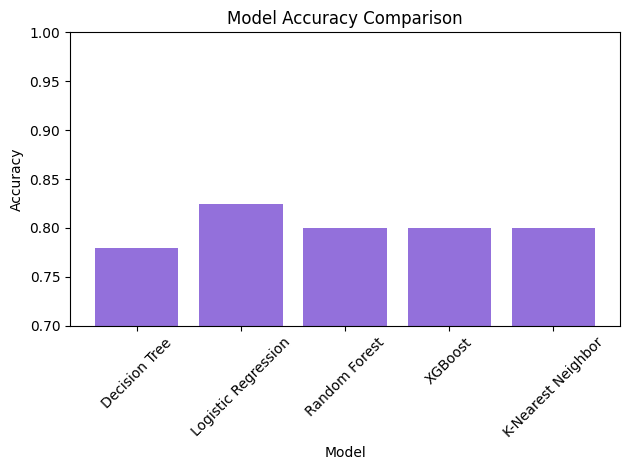

In [325]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(metrics_df["Model"], metrics_df["Accuracy"], color="mediumpurple")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


F1 Score Bar Chart

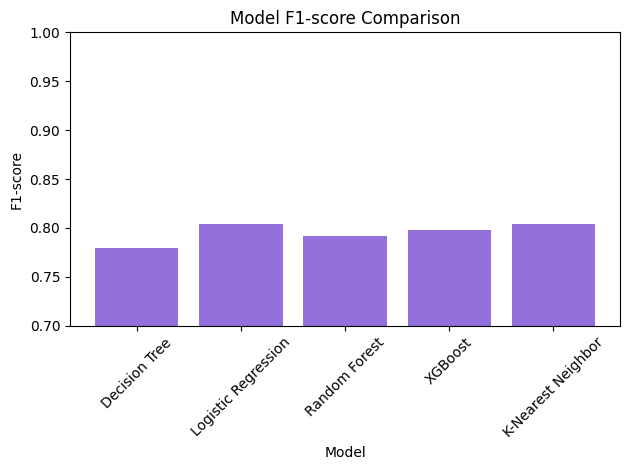

In [326]:
plt.figure()
plt.bar(metrics_df["Model"], metrics_df["F1 Score"], color="mediumpurple")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45)
plt.title("Model F1-score Comparison")
plt.xlabel("Model")
plt.ylabel("F1-score")
plt.tight_layout()
plt.show()

ROC-AUC Bar Chart

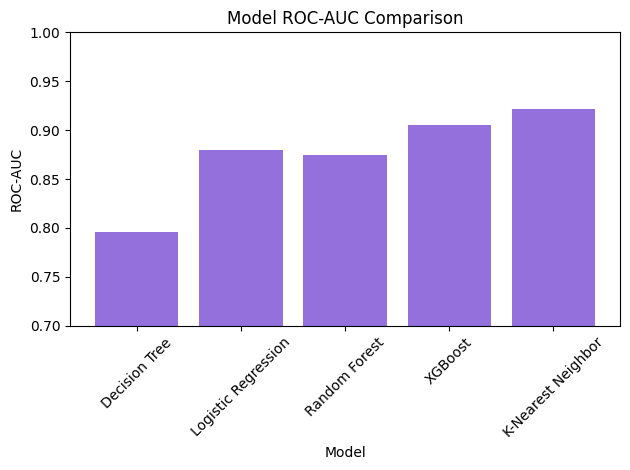

In [327]:
plt.figure()
plt.bar(metrics_df["Model"], metrics_df["ROC-AUC"], color="mediumpurple")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45)
plt.title("Model ROC-AUC Comparison")
plt.xlabel("Model")
plt.ylabel("ROC-AUC")
plt.tight_layout()
plt.show()

# LLM Interpretation & Insights (Hani)

In [390]:
!pip install google-generativeai

In [372]:
#Model Comparison
import pandas as pd

metrics_df = pd.read_csv("model_metrics_summary.csv")

# Standardize column names if needed (your file uses "F1 Score")
# If your file uses "F1 Score", keep it. If it's "F1-score", adjust here.
print("Metrics columns:", metrics_df.columns.tolist())

# Sort by ROC-AUC (best overall ranking for binary classification)
metrics_sorted = metrics_df.sort_values(by="ROC-AUC", ascending=False).reset_index(drop=True)
best_model_name = metrics_sorted.loc[0, "Model"]

print("=== Model Comparison (sorted by ROC-AUC) ===")
display(metrics_sorted)

print(f"\nBest model by ROC-AUC: {best_model_name}")


Metrics columns: ['Model', 'Accuracy', 'F1 Score', 'ROC-AUC']
=== Model Comparison (sorted by ROC-AUC) ===


,Model,Accuracy,F1 Score,ROC-AUC
0,K-Nearest Neighbor,0.800,0.804233,0.921825
1,XGBoost,0.800,0.797927,0.904898
2,Logistic Regression,0.825,0.804469,0.879357
3,Random Forest,0.800,0.791667,0.874299
4,Decision Tree,0.780,0.780000,0.795523



Best model by ROC-AUC: K-Nearest Neighbor


In [373]:
#listing top drivers for all models
import numpy as np

drivers_tables = {}

# Decision Tree feature importance
if "dt_model" in globals():
    dt_imp = pd.DataFrame({
        "Feature": feature_cols,
        "Importance": dt_model.feature_importances_
    }).sort_values("Importance", ascending=False)
    drivers_tables["Decision Tree"] = dt_imp

# Random Forest feature importance
if "rf_model" in globals():
    rf_imp = pd.DataFrame({
        "Feature": feature_cols,
        "Importance": rf.feature_importances_
    }).sort_values("Importance", ascending=False)
    drivers_tables["Random Forest"] = rf_imp

# XGBoost feature importance
if "xgb_model" in globals():
    xgb_imp = pd.DataFrame({
        "Feature": feature_cols,
        "Importance": xgb_model.feature_importances_
    }).sort_values("Importance", ascending=False)
    drivers_tables["XGBoost"] = xgb_imp

# Logistic Regression coefficients (absolute magnitude = importance)
if "log_reg" in globals():
    lr_coef = pd.DataFrame({
        "Feature": feature_cols,
        "Coef": log_reg.coef_.flatten(),
        "AbsCoef": np.abs(log_reg.coef_.flatten())
    }).sort_values("AbsCoef", ascending=False)
    drivers_tables["Logistic Regression"] = lr_coef

# Display top drivers for each model
for model_name, table in drivers_tables.items():
    print(f"\n=== Top drivers ({model_name}) ===")
    display(table.head(10))



=== Top drivers (Decision Tree) ===


,Feature,Importance
1,urgent_keywords_flag,0.437297
0,sentiment_score,0.392787
3,activity_level_enc,0.073553
4,priority_enc,0.053869
2,account_age_cat_enc,0.042495



=== Top drivers (XGBoost) ===


,Feature,Importance
1,urgent_keywords_flag,0.791590
0,sentiment_score,0.071450
4,priority_enc,0.059146
2,account_age_cat_enc,0.042372
3,activity_level_enc,0.035442



=== Top drivers (Logistic Regression) ===


,Feature,Coef,AbsCoef
1,urgent_keywords_flag,1.726576,1.726576
0,sentiment_score,-0.812676,0.812676
4,priority_enc,0.485621,0.485621
3,activity_level_enc,0.111664,0.111664
2,account_age_cat_enc,-0.070360,0.070360


In [374]:
evidence = {
     "project": "Customer Support Ticket Classification (Urgent vs Non-Urgent)",
    "dataset_size": "1000",
    "target_definition": "urgent_flag: 1 = Urgent, 0 = Non-Urgent",
    "key_points": [
        "Goal: automatically sort customer tickets and prioritize urgent cases faster",
        "Models compared using Accuracy, F1-score and ROC-AUC",
        "k-NN does not have native feature importance"
        ],
    "model_results": metrics_sorted.to_dict(orient='records'),
    "selected_model": best_model_name,
    "selection_reason": "selected based on highest ROC-AUC with strong F1-score (better separation + balanced performance)",
    "notes": "Dataset is simulated/synthetic"
}

In [375]:
#prompt for the evaluation metrics interpretations and conclude the best model interpretation

prompt_metrics_interpretations = f"""
You are generating LLM interpretations for a Data Mining and Warehousing group project.

Use the evidence to write these 3 sections:
A) Accuracy Interpretation
B) F1-score Interpretation
C) ROC-AUC Interpretation

Evidence:
{evidence}

Write in bullet points for each section.
Describe each section clearly, concisely and in detail.
Make sure to highlight on which model did the evaluation better than others.

"""


In [376]:
#Prompt for findings, best model conclusion and importance feature

prompt_findings_if = f"""
You are generating findings and feature importance of this project.

For the 1st paragraph, write the short summary for findings (EDA + modelling results).
Then, conclude the paragraph by writing the best model performs overall with reasons.

For the 2nd paragraph, list out in bullet points of the
feature importance of all of the models and xplain clearly its financial behaviour relation.
Prefarably find at least 5 most important features and explain why.

Evidence:
{evidence}

"""


In [377]:
#Prompt for business insigths and recommendations
prompt_insights_recommendations = f"""
Generate answer like a business analyst.
Provide several insights and recommendations that could help any business industries.

Evidence:
{evidence}

List out in bullet points:
-Strategy name
-What model/feature importance shows
-Clear recommendation action steps

Write in academic and formal style
"""

In [392]:
model = genai.GenerativeModel('gemini-3-flash-preview')

In [393]:
# Generate LLM interpretations
model_results = model.generate_content(prompt_metrics_interpretations).text
findings = model.generate_content(prompt_findings_if).text
insights = model.generate_content(prompt_insights_recommendations).text

# Display results clearly
print("===== LLM Interpretation =====\n")

print(">> Summary of Evaluation Metrics")
print(model_results)
print("\n--------------------------------\n")

print(">> Findings and Feature Importance")
print(findings)
print("\n--------------------------------\n")

print(">> Business Insights and Recommendations")
print(insights)

===== LLM Interpretation =====

>> Summary of Evaluation Metrics
Based on the evaluation results of the Customer Support Ticket Classification project, here is the interpretation of the performance metrics:

### A) Accuracy Interpretation
*   **Definition:** Accuracy measures the percentage of total tickets—both urgent and non-urgent—that were correctly classified by the model.
*   **Top Performer:** **Logistic Regression** achieved the highest accuracy at **82.5%**.
*   **General Performance:** Most models (k-NN, XGBoost, and Random Forest) maintained a consistent accuracy of **80%**, while the Decision Tree lagged slightly behind at 78%.
*   **Project Context:** While Logistic Regression was the most accurate overall, an 80-82.5% range across most models indicates a reliable baseline for the automated sorting system, ensuring approximately 4 out of every 5 tickets are categorized correctly.

### B) F1-score Interpretation
*   **Definition:** The F1-score is the harmonic mean of Preci